# Transfer Learning on Cats-Dogs Classification - Feature Extraction - Solution

### Features are extracted from a MobileNet-V2 model pre-trained on ImageNet data, then passed through a new classification head to classify cats vs. dogs.
### Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### SDSC HPC-DS Summer Institute, UC San Diego

## Setup

In [1]:
# --- Set logging level ---

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import random
import shutil
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from torch.utils.data import ConcatDataset, DataLoader
from torchmetrics.functional import accuracy
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision

plt.rcParams["figure.facecolor"] = "white"

In [3]:
# Set global random seed for reproducibility

def set_seed(seed=1234):
    os.environ["PYTHONHASHSEED"] = str(0)  # disable hash randomization
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    pl.seed_everything(seed, workers=False)

set_seed()

[rank: 0] Seed set to 1234


In [4]:
!jupyter --version
!python --version

Selected Jupyter core packages...
IPython          : 9.4.0
ipykernel        : 6.30.0
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.8.1
jupyter_server   : 2.16.0
jupyterlab       : 4.4.5
nbclient         : 0.10.2
nbconvert        : 7.16.6
nbformat         : 5.10.4
notebook         : not installed
qtconsole        : not installed
traitlets        : 5.14.3
Python 3.12.11


In [5]:
print(
    f"PyTorch version: {torch.__version__}\nPyTorch Lightning version: {pl.__version__}"
)

PyTorch version: 2.5.1
PyTorch Lightning version: 2.5.2


In [6]:
# Use linux shell command nvidia-smi to see GPU device.

!nvidia-smi

Tue Aug  5 15:31:46 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   33C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from os.path import expanduser
HOME = expanduser("~")

DATA_DIR = HOME + "/data/catsVsDogs"
CHECKPOINT_DIR = "models/feature_extraction"
IMG_DIM = 224
BATCH_SIZE = 16
ROTATION_DEGREES = 72
LEARNING_RATE = 0.0001
NUM_CPUS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Preprocessing and Data Augmentation

In [8]:
class Preprocess(nn.Module):
    def __init__(self, rescale: bool = False) -> None:
        super().__init__()
        self.rescale = rescale

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.rescale:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(
                        size=(IMG_DIM, IMG_DIM),
                        interpolation=transforms.InterpolationMode.BILINEAR,
                    ),
                    # Rescale to [-1, 1] range:
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(
                        size=(IMG_DIM, IMG_DIM),
                        interpolation=transforms.InterpolationMode.BILINEAR,
                    ),
                    transforms.PILToTensor(),
                ]
            )
        return self.transform(x)


class DataAugmentation(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.transforms = nn.Sequential(
            transforms.RandomAffine(degrees=0, shear=0.2),  # Shear
            transforms.RandomResizedCrop(
                size=IMG_DIM,
                scale=(0.8, 1.2),
                interpolation=transforms.InterpolationMode.NEAREST,
            ),  # Zoom
            transforms.RandomHorizontalFlip(),
        )

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.transforms(x)


## Define Data Module

In [9]:
class CatsDogsData(pl.LightningDataModule):
    """Cats and dogs dataset class."""

    def __init__(
        self,
        augment: bool = False,
        rescale: bool = False,
        batch_size: int = BATCH_SIZE,
        data_dir: str = DATA_DIR,
    ):
        super().__init__()
        self.augment = augment
        self.rescale = rescale
        self.batch_size = batch_size
        self.preprocess = Preprocess(self.rescale)
        self.transform = DataAugmentation()

    def prepare_data(self):
        """Load data and apply transforms."""
        if self.augment:
            train_orig = datasets.ImageFolder(
                root=os.path.join(DATA_DIR, "train"), transform=self.preprocess
            )
            train_aug = datasets.ImageFolder(
                root=os.path.join(DATA_DIR, "train"),
                transform=transforms.Compose([self.preprocess, self.transform]),
            )
            self.train_data = ConcatDataset([train_orig, train_aug])
        else:
            self.train_data = datasets.ImageFolder(
                root=os.path.join(DATA_DIR, "train"), transform=self.preprocess
            )
        self.val_data = datasets.ImageFolder(
            root=os.path.join(DATA_DIR, "val"), transform=self.preprocess
        )
        self.test_data = datasets.ImageFolder(
            root=os.path.join(DATA_DIR, "test"), transform=self.preprocess
        )

    def show_batch(self, win_size=(10, 10)):
        def _to_viz(data):
            return make_grid(data).permute(2, 1, 0)

        imgs, labels = (next(iter(self.train_dataloader())))
        plt.figure(figsize=win_size)
        plt.imshow(_to_viz(imgs))

    def train_dataloader(self):
        """Train DataLoader."""
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=NUM_CPUS)

    def val_dataloader(self):
        """Validation DataLoader."""
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=NUM_CPUS )

    def test_dataloader(self):
        """Test DataLoader."""
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=NUM_CPUS)


## Define Model

In [10]:
class MobileNetV2Model(pl.LightningModule):
    """MobileNetV2 model class."""

    def __init__(self):
        super().__init__()

        self.model = torch.hub.load(
            "pytorch/vision:v0.10.0", "mobilenet_v2", weights=torchvision.models.MobileNet_V2_Weights.DEFAULT, progress=False
        )

        self.accuracy = torchmetrics.Accuracy(task="binary").to(DEVICE)

        # Freeze the pretrained model weights
        for param in self.model.parameters():
            param.requires_grad = False

        # Top model
        self.model.pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2), nn.Linear(1280, 1), nn.Sigmoid()
        )


    def forward(self, x):
        return self.model(x.float())

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    def training_step(self, batch: int, batch_idx: int):
        """Training step. Perform data augmentation if specified."""
        X, y = batch
        logits = self(X.float()).view(-1)
        train_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        train_acc = self.accuracy(pred, y)

        self.log("train_loss", train_loss, on_epoch = True, on_step=False, prog_bar=True)
        self.log("train_acc", train_acc, on_epoch = True, on_step=False, prog_bar=True)
        return train_loss

    def validation_step(self, batch: int, batch_idx: int):
        """Validation step. Perform data augmentation if specified."""
        X, y = batch
        logits = self(X.float()).view(-1)
        valid_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        valid_acc = self.accuracy(pred, y)

        self.log("val_loss", valid_loss, prog_bar=True)
        self.log("val_acc", valid_acc, prog_bar=True)
        return valid_loss

    def test_step(self, batch: int, batch_idx: int):
        """Test step. Perform data augmentation if specified."""
        X, y = batch
        logits = self(X.float()).view(-1)
        test_loss = F.binary_cross_entropy(logits, y.float())
        pred = logits >= 0.5
        test_acc = self.accuracy(pred, y)

        return test_loss


## Train Model

In [11]:
# Prepare data and helpers

data = CatsDogsData(augment=True, rescale=True)
data.prepare_data()

def get_predict(model, data_loader):
    """Get predictions from model and DataLoader."""
    true_values = []
    predicted_values = []
    for imgs, labels in data_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        true_values.extend(labels)
        predicted_values.extend((outputs >= 0.5).view(-1).cpu().numpy())

    return true_values, predicted_values

In [12]:
# Define number of epochs
num_epochs = 5

# Define checkpoint callback
checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename=str(num_epochs) + "_{epoch:02d}-{step}",
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_top_k=1,
)

# Define trainer
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    max_epochs=num_epochs,
    callbacks=[checkpoint, TQDMProgressBar(refresh_rate=50)]
)

# Define and fit model
model = MobileNetV2Model()
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using cache found in /home/mhnguyen/.cache/torch/hub/pytorch_vision_v0.10.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | model    | MobileNetV2    | 2.2 M  | train
1 | accuracy | BinaryAccuracy | 0      | train
----------------------------------------------------
1.3 K     Trainable params
2.2 M     Non-trainable params
2.2 M     Total params
8.901     Total estimated model params size (MB)
216       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 250/250 [00:03<00:00, 64.69it/s, v_num=4.18e+7]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 250/250 [00:03<00:00, 64.46it/s, v_num=4.18e+7, val_loss=0.423, val_acc=0.947, train_loss=0.554, train_acc=0.843]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 250/250 [00:03<00:00, 64.51it/s, v_num=4.18e+7, val_loss=0.309, val_acc=0.962, train_loss=0.405, train_acc=0.917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 250/250 [00:03<00:00, 64.37it/s, v_num=4.18e+7, val_loss=0.247, val_acc=0.960, train_loss=0.333, train_acc=0.921]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 250/250 [00:03<00:00, 64.51it/s, v_num=4.18e+7, val_loss=0.217, val_acc=0.955, train_loss=0.290, train_acc=0.924]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 250/250 [00:04<00:00, 56.19it/s, v_num=4.18e+7, val_loss=0.196, val_acc=0.960, train_loss=0.268, train_acc=0

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 250/250 [00:04<00:00, 53.08it/s, v_num=4.18e+7, val_loss=0.196, val_acc=0.960, train_loss=0.268, train_acc=0.924]


In [13]:
# Saving model weights to path
model_path = "models/feature_extraction/best_model.ckpt"
trainer.save_checkpoint(model_path, weights_only=True)

# Evaluate Model

In [14]:
# Freeze model parameters for inference
model = MobileNetV2Model.load_from_checkpoint(checkpoint_path=model_path)
model = model.to(DEVICE)
model.freeze()

# Make predictions
y_train, pred_train = get_predict(model, data.train_dataloader())
y_val, pred_val = get_predict(model, data.val_dataloader())
y_test, pred_test = get_predict(model, data.test_dataloader())

# Print classification reports
print()
print(f"Train:\n {classification_report(y_train, pred_train, digits=4)}")
print(f"Val:\n {classification_report(y_val, pred_val, digits=4)}")
print(f"Test:\n {classification_report(y_test, pred_test, digits=4)}")


Using cache found in /home/mhnguyen/.cache/torch/hub/pytorch_vision_v0.10.0



Train:
               precision    recall  f1-score   support

           0     0.9315    0.9790    0.9547      2000
           1     0.9779    0.9280    0.9523      2000

    accuracy                         0.9535      4000
   macro avg     0.9547    0.9535    0.9535      4000
weighted avg     0.9547    0.9535    0.9535      4000

Val:
               precision    recall  f1-score   support

           0     0.9423    0.9800    0.9608       200
           1     0.9792    0.9400    0.9592       200

    accuracy                         0.9600       400
   macro avg     0.9607    0.9600    0.9600       400
weighted avg     0.9607    0.9600    0.9600       400

Test:
               precision    recall  f1-score   support

           0     0.9296    0.9900    0.9588       200
           1     0.9893    0.9250    0.9561       200

    accuracy                         0.9575       400
   macro avg     0.9594    0.9575    0.9575       400
weighted avg     0.9594    0.9575    0.9575       40

## Perform Inference

In [15]:
# helper method to prepare image for model inference
def image_loader(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    image = transform(image).unsqueeze(0).to(DEVICE)
    return image

In [16]:
!ls ~/data/catsVsDogs/test/cats/cat.1070.jpg

/home/mhnguyen/data/catsVsDogs/test/cats/cat.1070.jpg


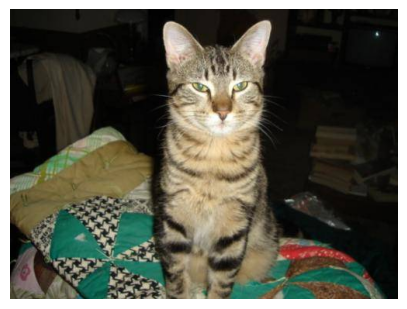


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1070.jpg: 
cat (0.0599)


In [17]:
image_path = DATA_DIR + "/test/cats/cat.1070.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

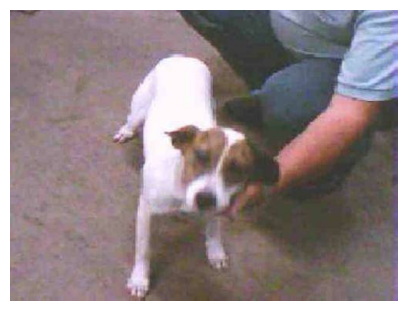


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1233.jpg: 
dog (0.8290)


In [18]:
image_path = DATA_DIR + "/test/dogs/dog.1233.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

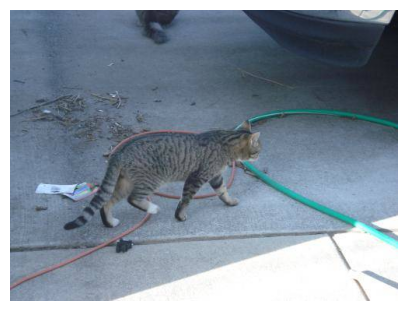


Prediction for /home/mhnguyen/data/catsVsDogs/test/cats/cat.1080.jpg: 
cat (0.3346)


In [19]:
image_path = DATA_DIR + "/test/cats/cat.1080.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

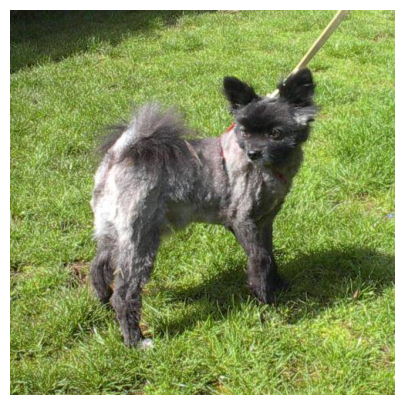


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1132.jpg: 
dog (0.6761)


In [20]:
image_path = DATA_DIR + "/test/dogs/dog.1132.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")

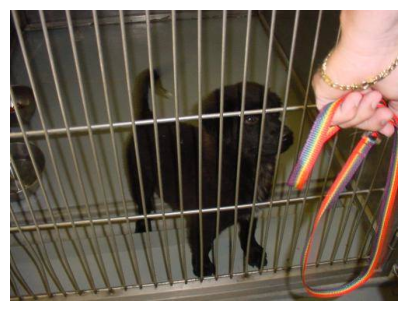


Prediction for /home/mhnguyen/data/catsVsDogs/test/dogs/dog.1311.jpg: 
cat (0.4239)


In [21]:
image_path = DATA_DIR + "/test/dogs/dog.1311.jpg"
img = image_loader(image_path)
with torch.no_grad():
    img_y_pred = model(img).item()

print()
print(f"Prediction for {image_path}: \n{'dog' if img_y_pred >= 0.5 else 'cat'} ({img_y_pred:.4f})")